# Iris dataset analysis

This notebook replicates in Jupyter the analysis of the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) in Excel that features in [this article](https://www.anaconda.com/blog/create-your-first-machine-learning-experiment-with-python-in-excel).


## Data retrieval and partitioning

We retrieve the data and then split into train and test subsets.

In [21]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)

X = iris.data
y = iris.target

ds_info_details = f"""
    {X.shape[0]} samples
    {X.shape[1]} features
    {y.values.ndim} target
"""
ds_info_details
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [22]:
y.to_frame()

,target
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [23]:
# partition the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=12345,
                                                    stratify=y)



## Feature extraction

#### Pairwise comparison of features

In the first visualisation we use pairwise plots of the input variables to see which pairs might best predict the iris classification and therefore be candidate features for a regression.

c:\Users\JulianElve\anaconda3\envs\learn\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


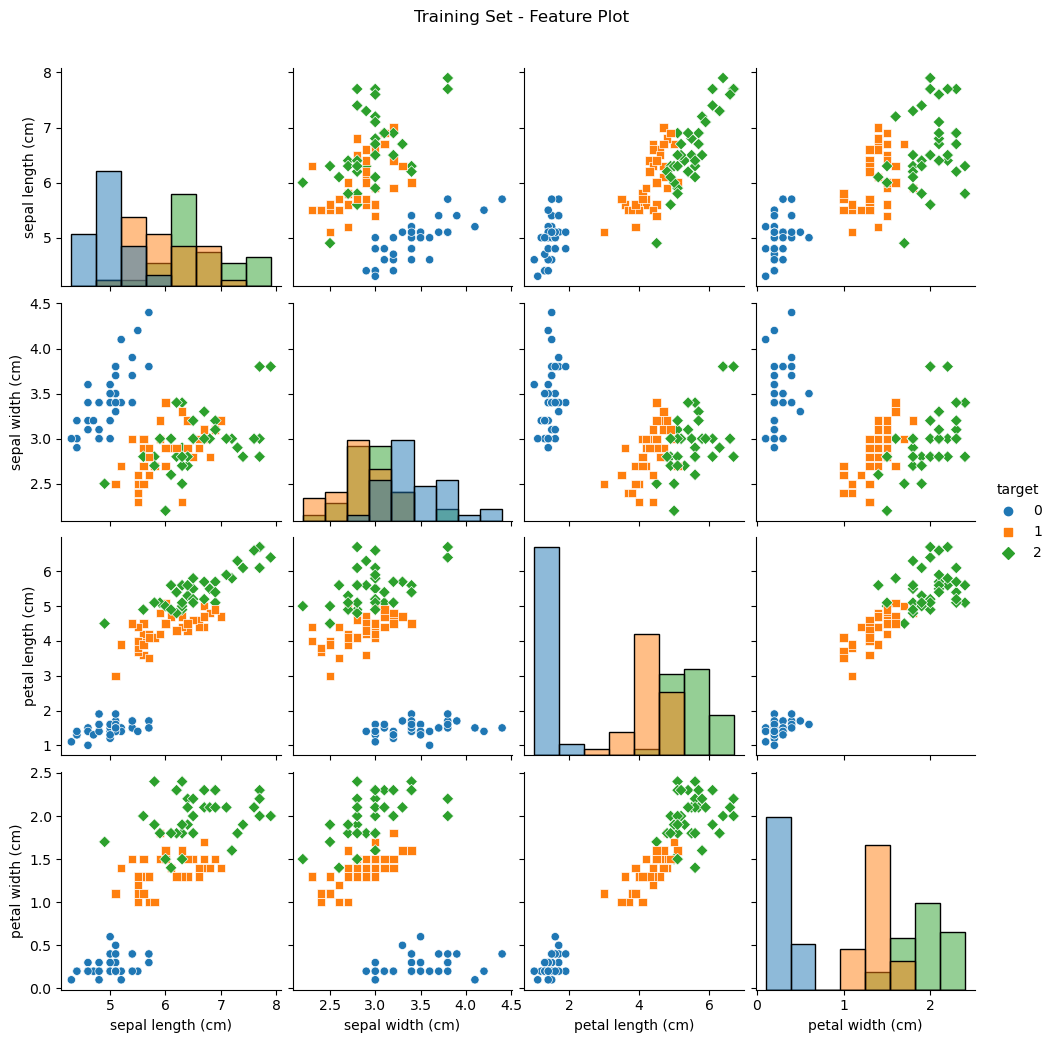

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt

def feature_plot(X, y, title):
    as_df = X.join(y)  # join features, and targets
    pplot = sns.pairplot(as_df, hue="target", markers=["o", "s", "D"],
                        diag_kind="hist", palette="tab10")
    pplot.fig.suptitle(title, y=1.04)                
    
feature_plot(X_train, y_train, title="Training Set - Feature Plot")

Visually, petal width v petal length looks a good bet for a clear classification.

### Principal component analysis

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (**PCA**) is a statistical technique for reducing the dimensionality of a dataset.

It extracts the new components by combining the existing variables into a new co-ordinate system such that the first principal component describes the greatest variance of the data, the second principal component describes the second greatest variance, and so on.

The relationship between principal components and data variance leads to the use of PCA as a way of selecting features for a regression analysis.

In this analysis we use the `scikit-learn` [implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to visualise the iris data against the first two principle components

In [25]:
import pandas as pd
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)

def scale_data(X, y):
    """Utility function to scale data, and join them into a unique data frame"""
    X_scaled = pca.transform(X)  # X_scaled is a numpy array
    X_scaled_df = pd.DataFrame(X_scaled, columns=["x1", "x2"])
    X_scaled_df["target"] = y.values
    return X_scaled_df

def plot_pca_components(X, y, title):
    """Utility function to visualize PCA components"""
    X_scaled_df = scale_data(X, y)        
    pca_plot = sns.relplot(data=X_scaled_df, x="x1", y="x2",
                          hue="target", palette="tab10")
    pca_plot.fig.suptitle(title, y=1.04)                           
    return pca_plot




c:\Users\JulianElve\anaconda3\envs\learn\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\JulianElve\anaconda3\envs\learn\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


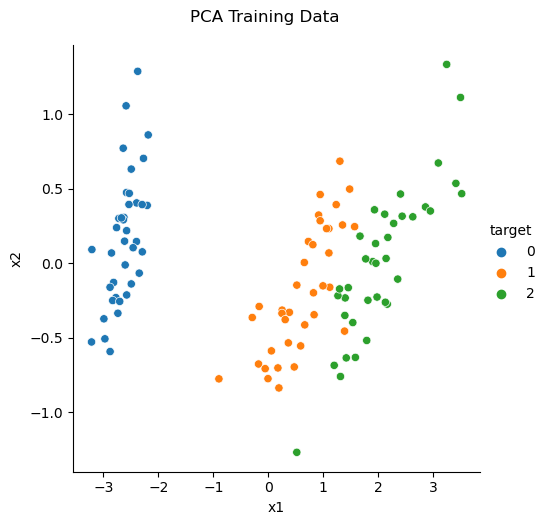

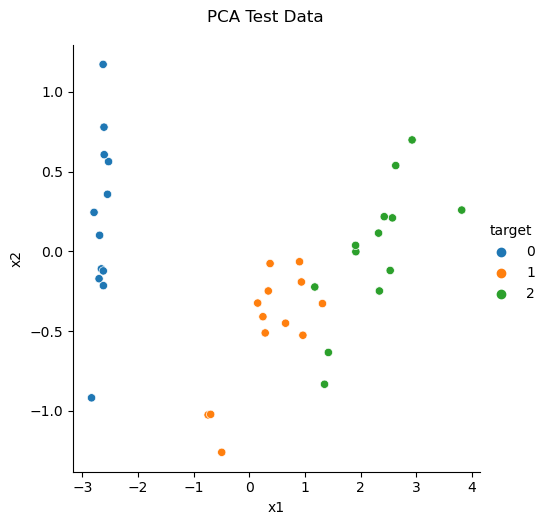

In [26]:
plot_pca_components(X_train, y_train, 'PCA Training Data')

plot_pca_components(X_test, y_test, 'PCA Test Data')

### Exploratory Clustering

Another way to explore the data set is to use clustering algorithms such as [K-means](https://towardsdatascience.com/k-means-a-complete-introduction-1702af9cd8c)]

The next analysis applies K-means clustering to the data set against the features identified by PCA and then plots the clusters visually compared to the target iris classification.

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init="auto")
X_train_scaled = pca.transform(X_train)
kmeans.fit(X_train_scaled)


c:\Users\JulianElve\anaconda3\envs\learn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, n_init='auto')

In [28]:
def visualize_kmeans_clustering(X, y, title):
    X_scaled = scale_data(X, y)
    features = X_scaled[["x1", "x2"]]

    y_cluster = kmeans.predict(features.values)
    X_scaled["cluster"] = y_cluster
   
    cluster_plot = sns.relplot(data=X_scaled, x="x1", y="x2",
                              hue="target", style="cluster", palette="tab10")
    cluster_plot.fig.suptitle(title, y=1.04)
    return cluster_plot

c:\Users\JulianElve\anaconda3\envs\learn\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


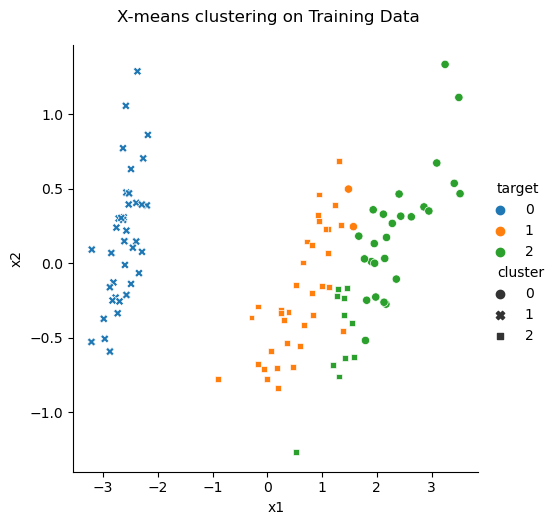

In [29]:
visualize_kmeans_clustering(X_train, y_train, 'X-means clustering on Training Data')

Visually the clusters are a pretty good match to the target values, with a small overlap between targets 1 and 2 (approx 6 data points mis-clustered).

### Classification with Logistic Regression

In this analysis we use the `scikit-learn` estimator [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to classify the test data set after training with the training data.

We plot the [Confusion Matrix]() to enable us to visually assess the quality of the regression.


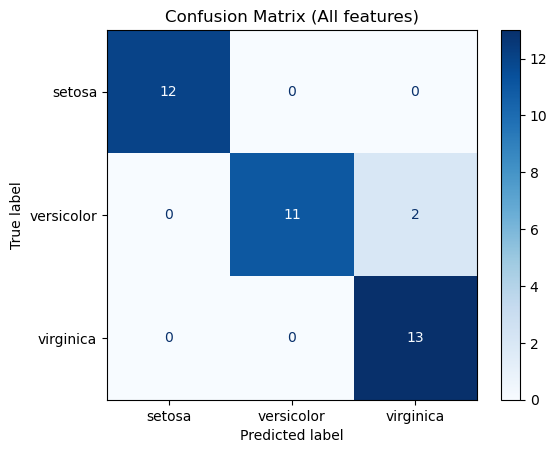

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=1e5).fit(X_train, y_train)
class_names = iris.target_names

disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
    )
disp.ax_.set_title("Confusion Matrix (All features)")
disp